<a href="https://colab.research.google.com/github/LawsonHutter/RNN_working_memory/blob/main/LinearDecoderTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [73]:
# Set some properties of the model. We'll store these in a dict so they're
# easier to pass around or save.
model = {}

# properties of the recurrent pool:
model['N'] = 1000  # number of neurons
model['g'] = 0.95  # gain of synaptic weights in pool
model['sp'] = 0.25  # fraction of weights that are nonzero
model['tau'] = 20  # neural membrane time constant in ms
model['dt'] = 0.1  # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x)  # firing rate nonlinearity for pool units

# properties of the input layer:
# a note: we're going to encode the "value" of the input by the identity of the
# active input layer units. We'll use one-hot encoding: for each input step
# during simulation, one unit will be activated with "firing rate" 1, and the
# rest will be set to firing rate 0 (adjust gIn to change the scaling of input
# to the recurrent pool.)
# Note 1: This is just one way of setting up input- are there other approaches
# that would improve memory capacity?
# Note 2: Burn-in time is especially important if your model has g>1, in which
# case neurons will be spontaneously active.
model['nIn'] = 20  # size of the input layer
model['gIn'] = 10.0  # gain of the input weights
model['spIn'] = 0.05  # sparsity of input->pool connectivity
model['burnIn'] = 10  # time before input starts
model['durIn'] = 1  # time for which an input is active in ms
model['ISI'] = 0  # time between inputs in ms
model['nonlinIn'] = lambda x: x  # best to keep the input linear

In [74]:
# Create the synaptic weight matrix.
# Normalizing weights by sqrt(N*sparsity) keeps the eigenvalue spectrum
# invariant to the size of the population N.
randMat  = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat  = np.random.uniform(0, 1, size=(model['N'], model['N'])) <= model['sp']
model['J'] = np.multiply(randMat, spMat) * model['g'] / math.sqrt(model['N'] * model['sp'])

# Create the input weight matrix.
randMatIn = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

In [75]:
# Define a couple helper functions for simulation.

def step(firing_rates, input_layer, model):
  # The simulation function. We use Euler's method to simulate the evolution of
  # model neuron firing rates given the input_layer firing rates.

  timestep = math.exp(-model['dt']/model['tau'])
  vIn = np.matmul(model['J'], firing_rates) \
        + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
  updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * timestep)

  return updated_rates


def make_input(sequence_length, model):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * int(model['burnIn']/model['dt'])

  for i in range(sequence_length):
    val = np.random.randint(0, model['nIn']) + 1
    for t in range(int(model['ISI']/model['dt'])):
      input_stream.append(0.0)
    for t in range(int(model['durIn']/model['dt'])):
      input_stream.append(val)

  input_stream = np.array(input_stream)

  onehot = np.zeros((model['nIn'] + 1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:, :]

  return onehot, input_stream

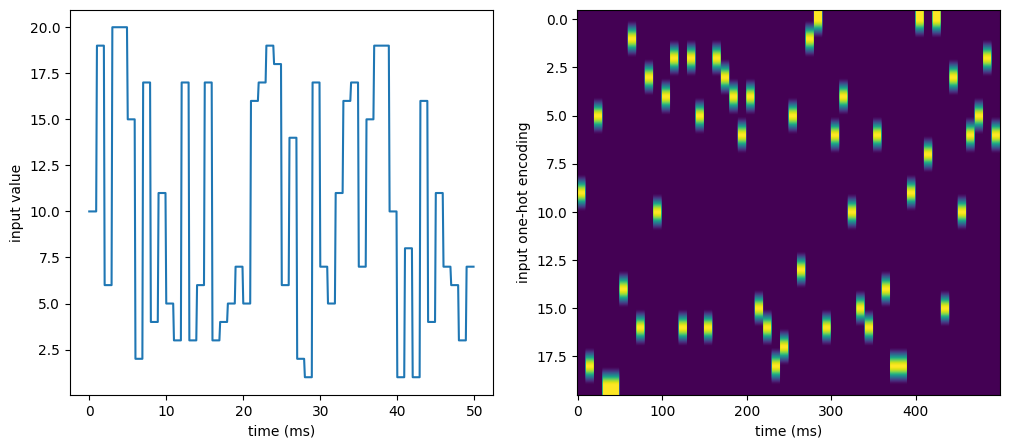

In [6]:
# Look at an example input stream.

onehot, stream = make_input(50, model)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
ax[0].plot(np.arange(len(stream) - omit) * model['dt'], stream[omit:])
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('input value')

ax[1].imshow(onehot[:, omit:], aspect='auto')
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('input one-hot encoding')
fig.show()

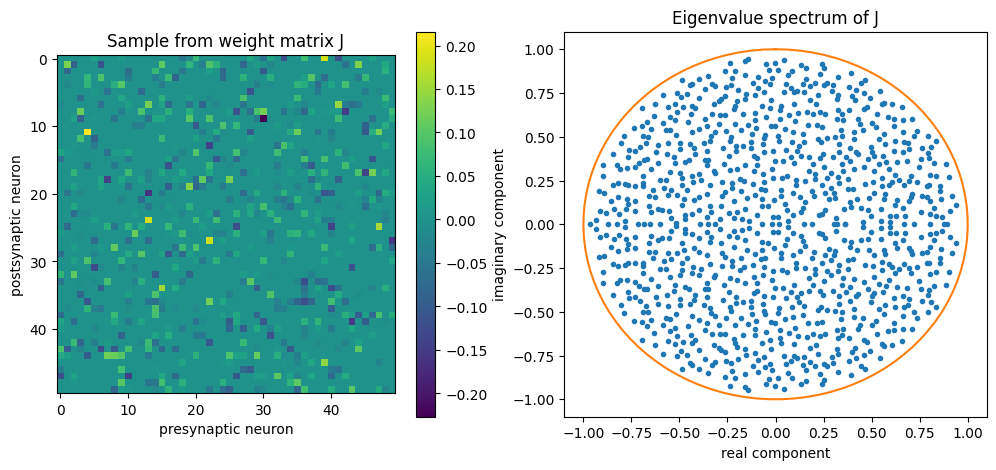

In [7]:
# Take a look at the eigenvalue spectrum of J.
w, v = np.linalg.eig(model['J'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
showCount = 50  # portion of J to actually show (for readability)
h = ax[0].imshow(model['J'][:showCount,:showCount])
ax[0].set_title('Sample from weight matrix J')
ax[0].set_xlabel('presynaptic neuron')
ax[0].set_ylabel('postsynaptic neuron')
plt.colorbar(h, ax=ax[0])

ax[1].plot(np.real(w),np.imag(w),'.')
ax[1].plot(np.sin(np.linspace(0,2*math.pi,100)),
           np.cos(np.linspace(0,2*math.pi,100)))  # circle with radius 1
ax[1].set_title('Eigenvalue spectrum of J')
ax[1].set_xlabel('real component')
ax[1].set_ylabel('imaginary component')
fig.show()

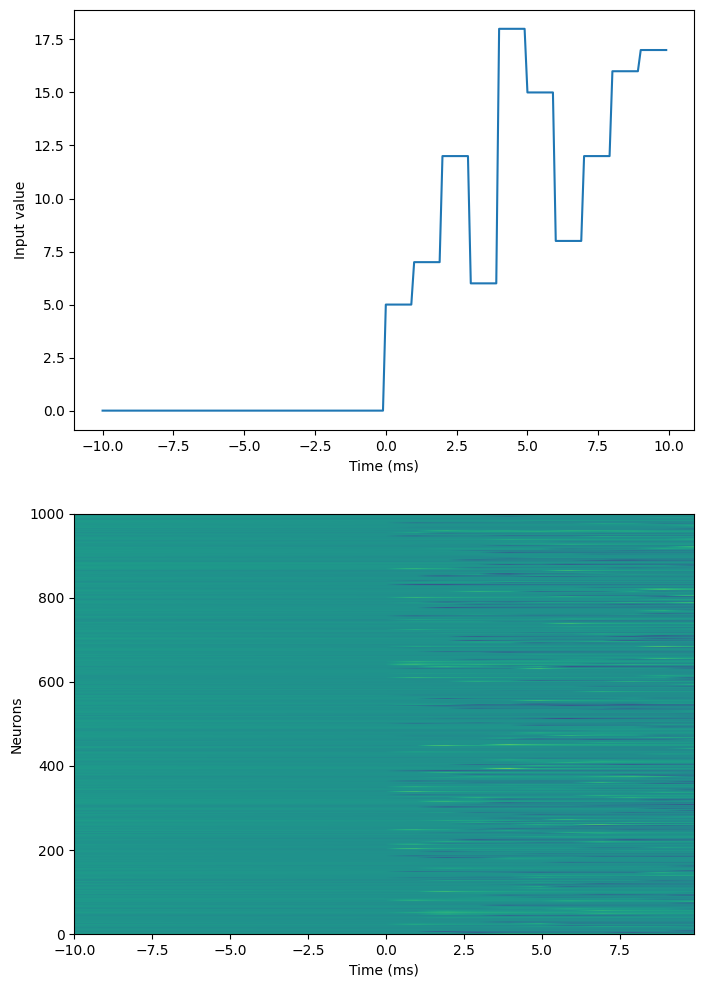

In [8]:
# Simulate the model activity.

# generate the input to the model
onehot, input_stream = make_input(10, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)


fig, ax = plt.subplots(2, 1, figsize=(8, 12))
simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time, input_stream)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Input value')

extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
ax[1].imshow(firing_rates, aspect='auto', extent=extents)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Neurons')
fig.show()

In [56]:
# Our Imports
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping
from keras.layers import TimeDistributed
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Q1)

In [111]:
sequence_length = 50

# Set G parameter
model['g'] = 1

# Generate Training Data
onehot, inputs_train = make_input(sequence_length, model)

# Generate Testing Data
onehot, inputs_test = make_input(sequence_length, model)

# initialize the firing rates for Training Data
firing_rates_train = np.zeros((model['N'], len(inputs_train)))
firing_rates_train[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(inputs_train)-1):
  firing_rates_train[:,t+1] = step(firing_rates_train[:,t], onehot[:,t], model)

# initialize the firing rates for Testing Data
firing_rates_test = np.zeros((model['N'], len(inputs_train)))
firing_rates_test[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(inputs_test)-1):
  firing_rates_test[:,t+1] = step(firing_rates_test[:,t], onehot[:,t], model)

# Set to numpy
inputs_train = np.array(inputs_train)
inputs_test = np.array(inputs_test)

firing_rates_train = np.array(firing_rates_train.T)
firing_rates_test = np.array(firing_rates_test.T)

In [112]:
# Determin X value and restructure data accordingly
max_X = 100

# New data sets for each value of x
Y_train = []
X_train = []

Y_test = []
X_test = []

# Restructure data, deleting the first x input sets and last x firing rates sets 
for x in range(1, max_X+1):
  # Training data
  input_temp_train = inputs_train[x:]
  rates_temp_train = firing_rates_train[:-(x), :]

  Y_train.append(input_temp_train)
  X_train.append(rates_temp_train)

  # Testing Data
  input_temp_test = inputs_test[x:]
  rates_temp_test = firing_rates_test[:-(x), :]

  Y_test.append(input_temp_test)
  X_test.append(rates_temp_test)

In [113]:
# Useful shapes to consider, (size-x, 1000)
print(Y_train[0].shape)
print(X_train[0].shape)
print(Y_test[0].shape)
print(X_test[0].shape)

(599,)
(599, 1000)
(599,)
(599, 1000)


In [114]:
# Define the grid of hyperparameters to search over
param_grid = {
    'alpha': [0.1],
    'solver': ['lsqr'], 
}

In [115]:
# Create a list to store the models
decoder_models = []

# Loop over the range of x values
for x in range(0, max_X):

    # Define the Ridge regression model
    ridge = Ridge(max_iter=1000)
    
    # Perform a grid search using 5-fold cross-validation
    grid_search = GridSearchCV(ridge, param_grid, cv=5)

    # Fit the grid search to the training data
    grid_search.fit(X_train[x], Y_train[x])

    # Define the model
    ridge = grid_search.best_estimator_
    
    # Append the model to the list
    decoder_models.append(ridge)

In [117]:
mse_list = []
r2_list = []

# Test the models for each value of x
for x in range(0, max_X):

    # Load the saved model for this value of x
    _model = decoder_models[x]

    # Predict the outputs for the test set
    predictions = _model.predict(X_test[x])

    # Calculate and print the mean squared error and R-squared for the predictions
    mse = mean_squared_error(Y_test[x], predictions)
    r2 = r2_score(Y_test[x], predictions)
    print(f'Model {x}: MSE = {mse:.4f}, R-squared = {r2:.4f}')

    mse_list.append(mse)
    r2_list.append(mse)

    # Plot the predicted outputs against the actual targets
    #plt.figure()
    #plt.scatter(Y_test[x], predictions)
    #plt.xlabel('Actual targets')
    #plt.ylabel('Predicted outputs')
    #plt.title(f'Model X = {x+1} predictions')
    #plt.show()

Model 0: MSE = 43.5617, R-squared = -0.1540
Model 1: MSE = 43.4665, R-squared = -0.1528
Model 2: MSE = 43.6635, R-squared = -0.1595
Model 3: MSE = 44.3270, R-squared = -0.1786
Model 4: MSE = 45.6427, R-squared = -0.2151
Model 5: MSE = 47.4068, R-squared = -0.2637
Model 6: MSE = 48.8061, R-squared = -0.3027
Model 7: MSE = 48.4017, R-squared = -0.2936
Model 8: MSE = 45.9549, R-squared = -0.2299
Model 9: MSE = 43.1693, R-squared = -0.1569
Model 10: MSE = 43.8728, R-squared = -0.1774
Model 11: MSE = 47.1937, R-squared = -0.2682
Model 12: MSE = 51.9821, R-squared = -0.3989
Model 13: MSE = 56.8966, R-squared = -0.5333
Model 14: MSE = 60.7822, R-squared = -0.6404
Model 15: MSE = 62.5726, R-squared = -0.6912
Model 16: MSE = 61.1676, R-squared = -0.6556
Model 17: MSE = 56.8936, R-squared = -0.5423
Model 18: MSE = 51.8108, R-squared = -0.4066
Model 19: MSE = 45.2450, R-squared = -0.2302
Model 20: MSE = 42.5626, R-squared = -0.1591
Model 21: MSE = 42.1296, R-squared = -0.1491
Model 22: MSE = 42.7

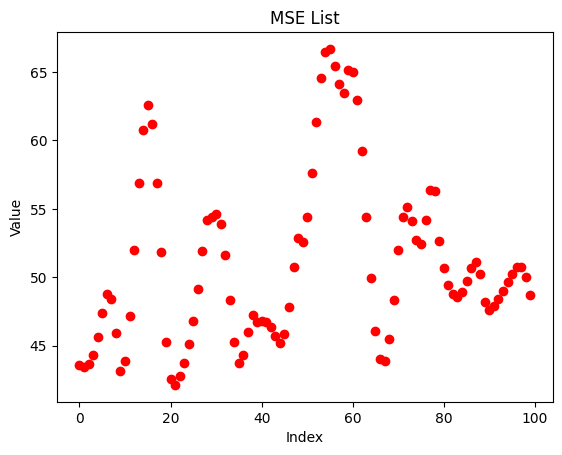

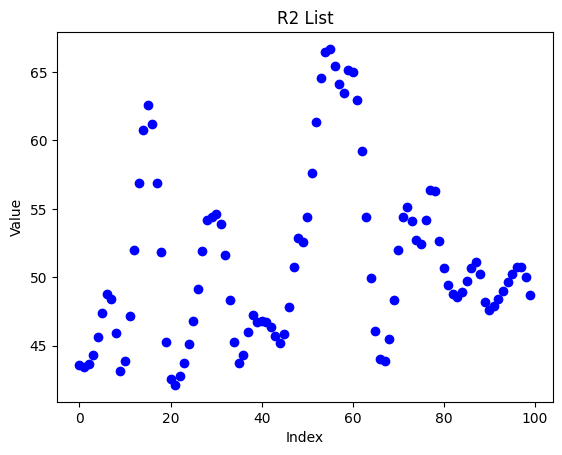

In [118]:
# plot the values in mse_list
plt.plot(mse_list, 'ro')
plt.title('MSE List')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

# plot the values in r2_list
plt.plot(r2_list, 'bo')
plt.title('R2 List')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

Model 21: MSE = 42.1296, R-squared = -0.1491


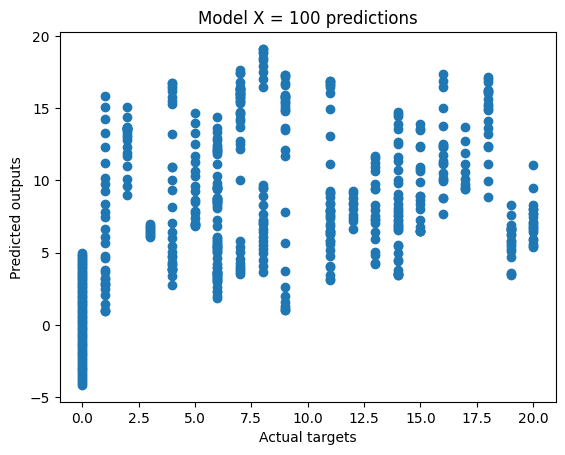

In [121]:
  # Load the saved model for this value of x
  _model = decoder_models[21]

  # Predict the outputs for the test set
  predictions = _model.predict(X_test[21])

  # Calculate and print the mean squared error and R-squared for the predictions
  mse = mean_squared_error(Y_test[21], predictions)
  r2 = r2_score(Y_test[21], predictions)
  print(f'Model {21}: MSE = {mse:.4f}, R-squared = {r2:.4f}')

  mse_list.append(mse)
  r2_list.append(mse)

  # Plot the predicted outputs against the actual targets
  plt.figure()
  plt.scatter(Y_test[21], predictions)
  plt.xlabel('Actual targets')
  plt.ylabel('Predicted outputs')
  plt.title(f'Model X = {x+1} predictions')
  plt.show()